In [1]:
import numpy as np
import pandas as pd
import bz2
import gc
import chardet
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, LSTM
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from tensorflow.keras.constraints import max_norm

sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Read Train & Test Files

###### https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/download?datasetVersionNumber=7

### Convert from raw binary strings to strings that can be parsed

In [2]:
def assign_labels_and_comments(file):
    labels = []
    comments = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        comments.append(x[10:].strip())
    return np.array(labels), comments
train_labels, train_text = assign_labels_and_comments('data/Amazon Reviews/train.ft.txt.bz2')
test_labels, test_text = assign_labels_and_comments('data/Amazon Reviews/test.ft.txt.bz2')

In [3]:
print(train_labels[0],'/n')
print(train_text[0])

1 /n
Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


In [4]:
not_numChar = re.compile(r'[\W]')
no_encode = re.compile(r'[^a-z0-1\s]')
def normalisation(texts):
    norm_text = []
    for word in texts:
        lower = word.lower()
        not_punct = not_numChar.sub(r' ', lower)
        exclude_no_encode = no_encode.sub(r'', not_punct)
        norm_text.append(exclude_no_encode)
    return norm_text

In [5]:
train_text = normalisation(train_text)
test_text = normalisation(test_text)

In [6]:
print(train_text[0])

stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    


In [7]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [8]:
y_test.shape

(400000,)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

max_features = 8192
maxlen = 128
embed_size = 64

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text)

In [10]:
training_token = tokenizer.texts_to_sequences(train_text)
testing_token = tokenizer.texts_to_sequences(test_text)

In [11]:
x_train = pad_sequences(training_token, maxlen = maxlen, padding = 'post')
x_test = pad_sequences(testing_token, maxlen = maxlen, padding = 'post')

In [12]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_lstm.compile('adam', 'binary_crossentropy', metrics = ['accuracy'], steps_per_execution=16)
model_lstm.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           524288    
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 557569 (2.13 MB)
Trainable params: 557569 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history_lstm = model_lstm.fit(x_train, y_train, batch_size = 32, epochs = 2, validation_data = (x_test, y_test), verbose = 2)

Epoch 1/2
112500/112500 - 3447s - loss: 0.1614 - accuracy: 0.9383 - val_loss: 0.1429 - val_accuracy: 0.9467 - 3447s/epoch - 31ms/step
Epoch 2/2
112500/112500 - 3604s - loss: 0.1338 - accuracy: 0.9504 - val_loss: 0.1364 - val_accuracy: 0.9492 - 3604s/epoch - 32ms/step


In [21]:
preds = model_lstm.evaluate(x_test, y_test)
preds

12500/12500 [==============================] - 140s 11ms/step - loss: 0.1364 - accuracy: 0.9492


[0.1363833248615265, 0.9491674900054932]

12500/12500 [==============================] - 143s 11ms/step
Accuracy score of the RNN Model: 0.949
F1 score of the RNN Model: 0.949
ROC AUC score of the RNN Model: 0.988


<Figure size 640x480 with 0 Axes>

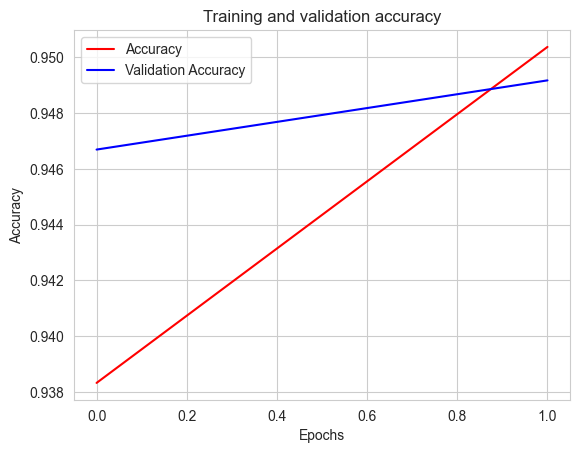

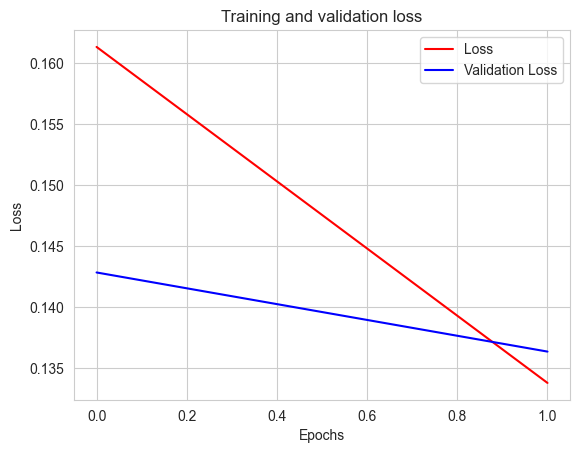

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_lstm.history['accuracy']
val_acc=history_lstm.history['val_accuracy']
loss=history_lstm.history['loss']
val_loss=history_lstm.history['val_loss']

rnn_preds = model.predict(x_test)

accuracy_rnn = accuracy_score(y_test, 1 * (rnn_preds > 0.5))
f1_rnn = f1_score(y_test, 1 * (rnn_preds > 0.5))
rocauc_rnn = roc_auc_score(y_test, rnn_preds)

print('Accuracy score of the RNN Model: {:0.3}'.format(accuracy_rnn))
print('F1 score of the RNN Model: {:0.3}'.format(f1_rnn))
print('ROC AUC score of the RNN Model: {:0.3}'.format(rocauc_rnn))

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [16]:
import keras
model_lstm.save('my_model.keras')

In [17]:
model = keras.models.load_model("my_model.keras")

In [24]:
# Let's check:
np.testing.assert_allclose(
    model_lstm.predict(x_test), model.predict(x_test)
)

12500/12500 [==============================] - 143s 11ms/step
